In [1]:
import os
import time

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [14]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PATH
TRAIN_AUG_CSV_PATH = '/upstage-cv-classification-cv2/data/train_translate_aug.csv'
TRAIN_AUG_IMAGE_PATH = '/upstage-cv-classification-cv2/data/train_translate_aug'

VALID_CSV_PATH = '/upstage-cv-classification-cv2/data/valid.csv'
VALID_IMAGE_PATH = '/upstage-cv-classification-cv2/data/valid'

TEST_CSV_PATH = '/upstage-cv-classification-cv2/data/sample_submission.csv'
TEST_IMAGE_PATH = '/upstage-cv-classification-cv2/data/test'

RESULT_CSV_PATH = '/upstage-cv-classification-cv2'

WANDB_PROJECT_NAME = 'white margin or not'
WANDB_RUN_NAME = 'translate_aug'

# HyperParameter

In [15]:
# training config
img_size = 380
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

patience = 5
min_delta = 0.001 # 성능 개선의 최소 변화량

# 1. DATA LOAD

In [16]:
# test image 변환
data_transform = A.Compose([
    A.Resize(height = img_size, width = img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2()
])

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image = img)['image']
    
        return img, target

    def get_labels(self):
        return self.df[:, 1] 

trn_dataset = ImageDataset(
    TRAIN_AUG_CSV_PATH,
    TRAIN_AUG_IMAGE_PATH,
    transform = data_transform
)

val_dataset = ImageDataset(
    VALID_CSV_PATH,
    VALID_IMAGE_PATH,
    transform = data_transform
)

tst_dataset = ImageDataset(
    TEST_CSV_PATH,
    TEST_IMAGE_PATH,
    transform = data_transform
)

labels = trn_dataset.get_labels()
labels = labels.astype(int)

# DataLoader
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    pin_memory = True,
    drop_last = False
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

print(len(trn_dataset), len(tst_dataset))

84780 3140


# 2. Model Train

In [17]:
torch.cuda.empty_cache()

In [18]:
# model
model = timm.create_model('efficientnet_b4',
                        pretrained=True,
                        num_classes = 17).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b4.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b4.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [ ]:
model

In [19]:
def valid_one_epoch(loader, model, loss_fn, device, epoch):
    model.eval()
    valid_loss = 0

    preds_list =[]
    targets_list = []

    with torch.no_grad():
        pbar = tqdm(loader)
        for step, (image, targets) in enumerate(pbar):
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)
       
            valid_loss += loss.item()
        
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Loss: {loss.item():.4f}")

            wandb.log({
                "valid_step" : epoch * len(loader) + step,
                "valid_loss_step" : loss.item()
            })

    valid_loss /= len(loader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "epoch" : epoch,
        "valid_loss" : valid_loss,
        "valid_acc" : valid_acc,
        "valid_f1" : valid_f1
    }

    wandb.log({
        "valid_epoch" : epoch,
        "val_loss_epoch" : valid_loss,
        "val_acc" : valid_acc,
        "val_f1" : valid_f1
    })

    return ret

In [20]:
# one epoch 학습
def train_one_epoch(train_loader, model, optimizer, loss_fn, device, epoch):    
    model.train()
    train_loss = 0
    preds_list =[]
    targets_list = []

    pbar = tqdm(train_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

        wandb.log({
            "train_step" : epoch * len(train_loader) + step,
            "train_loss_step" : loss.item()
        })

     
        
    train_loss /= len(train_loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "model" : model,
        "train_epoch" : epoch,
        "train_loss" : train_loss,
        "tarin_acc" : train_acc,
        "train_f1" : train_f1
    }

    wandb.log({
        "train_epoch" : epoch,
        "train_loss_epoch" : train_loss,
        "train_acc" : train_acc,
        "train_f1" : train_f1
    })

    return ret

In [21]:
os.environ['WANDB_SILENT'] = 'true'

f1_scores = []
valid_losses = []
trained_models = []
patience_counter = 0
best_loss = 1

wandb.init(project=WANDB_PROJECT_NAME, name=WANDB_RUN_NAME)

for epoch in range(EPOCHS):
    print(f"{epoch} epoch")
    trn_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)
    val_ret =  valid_one_epoch(val_loader, model, loss_fn, device, epoch)

    f1_scores.append(val_ret['valid_f1'])
    valid_losses.append(val_ret['valid_loss'])
    trained_models.append(model)

    print(f"valid loss : {val_ret['valid_loss']}")
    print(f"valid f1 : {val_ret['valid_f1']}")

    # 성능 개선 됨
    if val_ret['valid_loss'] < best_loss - min_delta:
        print(f"성능 개선 됨 : {val_ret['valid_loss']} > {best_loss - min_delta}")
        best_loss = val_ret['valid_loss']
        patience_counter = 0  
        
    # 성능 개선 되지 않음
    else:
        patience_counter += 1  
        print(f"성능 개선 안됨 : {val_ret['valid_loss']} > {best_loss - min_delta}")
        print(f"patience counter : {patience_counter}")

    # 성능 개선이 patience 만큼 안되면 학습 중단
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    

best_model_idx = np.argmax(np.array(f1_scores))
best_model = trained_models[best_model_idx]

wandb.finish()

0 epoch


Loss: 0.5229: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


valid loss : 0.4222670763731003
valid f1 : 0.8969416632626228
성능 개선 됨 : 0.4222670763731003 > 0.999
1 epoch


Loss: 0.4039: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


valid loss : 0.667561012506485
valid f1 : 0.8764532751089991
성능 개선 안됨 : 0.667561012506485 > 0.4212670763731003
patience counter : 1
2 epoch


Loss: 0.9775: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


valid loss : 0.5932139486074448
valid f1 : 0.8873092518761672
성능 개선 안됨 : 0.5932139486074448 > 0.4212670763731003
patience counter : 2
3 epoch


Loss: 0.3207: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


valid loss : 0.6456995859742165
valid f1 : 0.9169573733687595
성능 개선 안됨 : 0.6456995859742165 > 0.4212670763731003
patience counter : 3
4 epoch


Loss: 0.7876: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


valid loss : 0.8853869527578354
valid f1 : 0.8923799745281202
성능 개선 안됨 : 0.8853869527578354 > 0.4212670763731003
patience counter : 4
5 epoch


Loss: 1.6378: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


valid loss : 1.0967610582709313
valid f1 : 0.8757451159617442
성능 개선 안됨 : 1.0967610582709313 > 0.4212670763731003
patience counter : 5
Early stopping at epoch 5


# TEST

In [22]:
preds_list = []

best_model.eval()

for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = best_model(image)
        
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list
pred_df.to_csv(f"{RESULT_CSV_PATH}/translate_result.csv", index=False)

100%|██████████| 99/99 [00:15<00:00,  6.19it/s]


In [23]:
torch.save(best_model.state_dict(), '/upstage-cv-classification-cv2/results/translate.pth')

# model 성능 확인

In [ ]:
preds_list = []
targets_list = []

best_model.eval()

with torch.no_grad():
    pbar = tqdm(val_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        preds = best_model(image)
        print(f"step : {step}")
        print(f"preds : {preds}")
        loss = loss_fn(preds, targets)
    
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.8499: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


In [35]:
print("Classification Report:")
print(classification_report(targets_list, preds_list, target_names=[str(i) for i in range(17)]))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.93      1.00      0.96        13
           2       1.00      0.95      0.97        20
           3       0.47      0.67      0.55        12
           4       0.81      0.76      0.79        17
           5       0.94      1.00      0.97        16
           6       0.87      0.93      0.90        29
           7       0.60      0.45      0.51        20
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00        12
          10       0.87      1.00      0.93        20
          11       0.92      0.85      0.88        13
          12       1.00      1.00      1.00        22
          13       0.94      0.94      0.94        17
          14       0.83      0.71      0.77        14
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        16

   

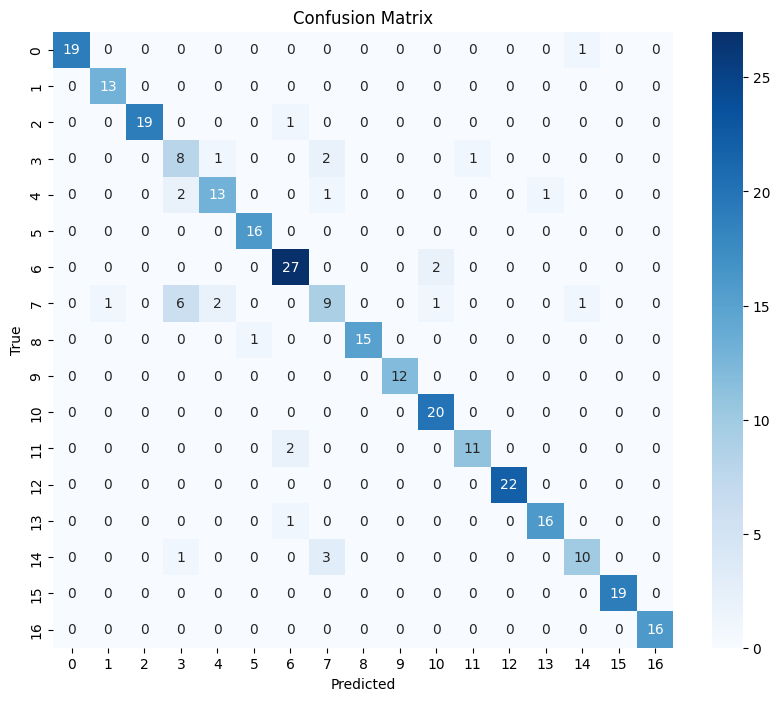

In [37]:
cm = confusion_matrix(targets_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()